## Training

In [ ]:
import json
import random
from collections import defaultdict, Counter
from tqdm import tqdm
import math

# -------------------
# Load train/val/test
# -------------------
with open("train-data.json") as f:
    train_data = json.load(f)
with open("val-data.json") as f:
    val_data = json.load(f)
with open("test-data.json") as f:
    test_data = json.load(f)

# Convert from [{word:tag}, ...] to list of (word, tag)
def convert_back(data):
    return [[(list(d.keys())[0].lower(), list(d.values())[0]) for d in sent] for sent in data]

train_data = convert_back(train_data)
val_data   = convert_back(val_data)
test_data  = convert_back(test_data)

# -------------------
# HMM Training (MLE)
# -------------------
class HMMTagger:
    def __init__(self):
        self.tags = set()
        self.words = set()
        self.init_probs = defaultdict(float)
        self.trans_probs = defaultdict(lambda: defaultdict(float))
        self.emit_probs = defaultdict(lambda: defaultdict(float))
        self.smoothing = 1e-6  # for unseen cases

    def train(self, tagged_sentences):
        tag_counts = Counter()
        init_counts = Counter()
        trans_counts = defaultdict(Counter)
        emit_counts = defaultdict(Counter)

        for sent in tqdm(tagged_sentences, desc="Training HMM"):
            prev_tag = None
            for i, (word, tag) in enumerate(sent):
                self.tags.add(tag)
                self.words.add(word)
                tag_counts[tag] += 1
                emit_counts[tag][word] += 1

                if i == 0:
                    init_counts[tag] += 1
                if prev_tag is not None:
                    trans_counts[prev_tag][tag] += 1
                prev_tag = tag

        # Normalize → probabilities
        total_sent = len(tagged_sentences)
        self.init_probs = {tag: init_counts[tag] / total_sent for tag in tag_counts}

        self.trans_probs = {
            t1: {t2: (trans_counts[t1][t2] / tag_counts[t1]) for t2 in tag_counts}
            for t1 in tag_counts
        }

        self.emit_probs = {
            tag: {w: emit_counts[tag][w] / tag_counts[tag] for w in emit_counts[tag]}
            for tag in tag_counts
        }

    # -------------------
    # Viterbi Decoding
    # -------------------
    def viterbi(self, sentence):
        V = [{}]  # V[t][tag] = max prob of seq ending in tag
        backpointer = [{}]

        # Initialization
        for tag in self.tags:
            emit_p = self.emit_probs.get(tag, {}).get(sentence[0], self.smoothing)
            if emit_p <= 0:
                emit_p = self.smoothing
            init_p = self.init_probs.get(tag, self.smoothing)
            if init_p <= 0:
                init_p = self.smoothing
            V[0][tag] = math.log(init_p) + math.log(emit_p)
            backpointer[0][tag] = None


        # Recursion
        for t in range(1, len(sentence)):
            V.append({})
            backpointer.append({})
            for tag in self.tags:
                emit_p = self.emit_probs.get(tag, {}).get(sentence[t], self.smoothing)
                if emit_p <= 0:
                    emit_p = self.smoothing

                max_prob, best_prev = max(
                    (
                        V[t-1][prev_tag]
                        + math.log(self.trans_probs.get(prev_tag, {}).get(tag, self.smoothing) or self.smoothing)
                        + math.log(emit_p),
                        prev_tag,
                    )
                    for prev_tag in self.tags
                )
                V[t][tag] = max_prob
                backpointer[t][tag] = best_prev


        # Termination
        last_tag = max(V[-1], key=V[-1].get)
        best_path = [last_tag]
        for t in range(len(sentence)-1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])

        return best_path


# -------------------
# Train + Example
# -------------------
hmm = HMMTagger()
hmm.train(train_data)

# Try tagging a sentence from test
test_sentence = [w for (w, t) in test_data[0]]
print("Sentence:", test_sentence)
print("Predicted Tags:", hmm.viterbi(test_sentence))
print("True Tags:", [t for (w, t) in test_data[0]])

Training HMM: 100%|██████████| 48739/48739 [00:00<00:00, 60921.25it/s]


Sentence: ['Well', ',', 'now', 'she', 'can', 'sleep', 'in', 'the', 'street', 'for', 'all', 'I', 'care', "''", '!', '!']
Predicted Tags: ['ADV', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'PRT', 'PRON', 'VERB', '.', '.', '.']
True Tags: ['PRT', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'PRT', 'PRON', 'VERB', '.', '.', '.']


## Testing

Classification Report:
              precision    recall  f1-score   support

           .     0.9958    0.9999    0.9978      8003
         ADJ     0.8797    0.8828    0.8812      2883
         ADP     0.9242    0.9505    0.9371      4987
         ADV     0.9040    0.8884    0.8962      2778
        CONJ     0.9916    0.9970    0.9943      1658
         DET     0.9458    0.9734    0.9594      5270
        NOUN     0.9516    0.9082    0.9294      9306
         NUM     0.8850    0.9788    0.9295       283
        PRON     0.9305    0.9907    0.9597      3530
         PRT     0.8972    0.8911    0.8941      1744
        VERB     0.9614    0.9546    0.9580      8412
           X     0.7568    0.2828    0.4118        99

    accuracy                         0.9474     48953
   macro avg     0.9186    0.8915    0.8957     48953
weighted avg     0.9473    0.9474    0.9469     48953



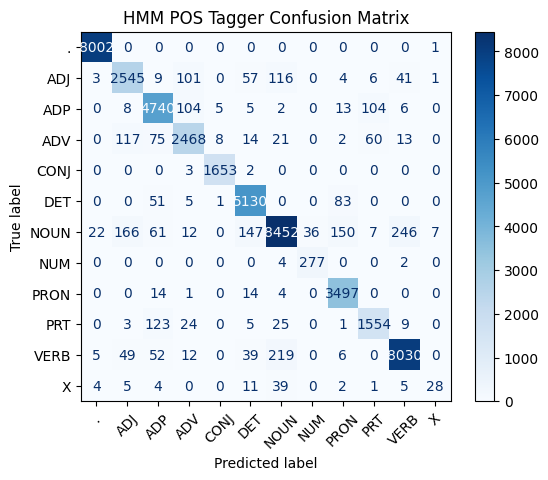

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(hmm, test_data):
    y_true, y_pred = [], []

    for sent in test_data:
        words = [w for w, t in sent]
        true_tags = [t for w, t in sent]
        pred_tags = hmm.viterbi(words)

        y_true.extend(true_tags)
        y_pred.extend(pred_tags)

    # Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    labels = sorted(list(hmm.tags))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("HMM POS Tagger Confusion Matrix")
    plt.show()

    return y_true, y_pred

# Run evaluation
y_true, y_pred = evaluate(hmm, test_data)


In [3]:
# -------------------
# Demo: show predictions
# -------------------
def show_predictions(hmm, test_data, n=5):
    print("\n--- Demo Predictions ---")
    for i, sent in enumerate(random.sample(test_data, n)):
        words = [w for w, t in sent]
        true_tags = [t for w, t in sent]
        pred_tags = hmm.viterbi(words)

        print(f"\nSentence {i+1}:")
        print("Words:     ", " ".join(words))
        print("True Tags: ", " ".join(true_tags))
        print("Pred Tags: ", " ".join(pred_tags))

# Show 5 random sentences
show_predictions(hmm, test_data, n=5)


--- Demo Predictions ---

Sentence 1:
Words:      Cady Partlow's head came up like that of the proverbial fire horse .
True Tags:  NOUN NOUN NOUN VERB PRT ADP DET ADP DET ADJ NOUN NOUN .
Pred Tags:  ADP DET NOUN VERB PRT VERB ADP ADP DET ADJ NOUN NOUN .

Sentence 2:
Words:      Eddie Lee moved over to Mike Deegan's side .
True Tags:  NOUN NOUN VERB PRT ADP NOUN NOUN NOUN .
Pred Tags:  NOUN NOUN VERB PRT ADP NOUN ADP NOUN .

Sentence 3:
Words:      Francesca and Herbert considered themselves violently nonconformist and showed the world they were by filling their Colonial house with contemporary furniture and paintings and other art objects ( expensive , but not necessarily valuable , contemporary things ) .
True Tags:  NOUN CONJ NOUN VERB PRON ADV NOUN CONJ VERB DET NOUN PRON VERB ADP VERB DET ADJ NOUN ADP ADJ NOUN CONJ NOUN CONJ ADJ NOUN NOUN . ADJ . CONJ ADV ADV ADJ . ADJ NOUN . .
Pred Tags:  NOUN CONJ NOUN VERB PRON ADV . CONJ VERB DET NOUN PRON VERB ADP VERB DET ADJ NOUN ADP ADJ NO

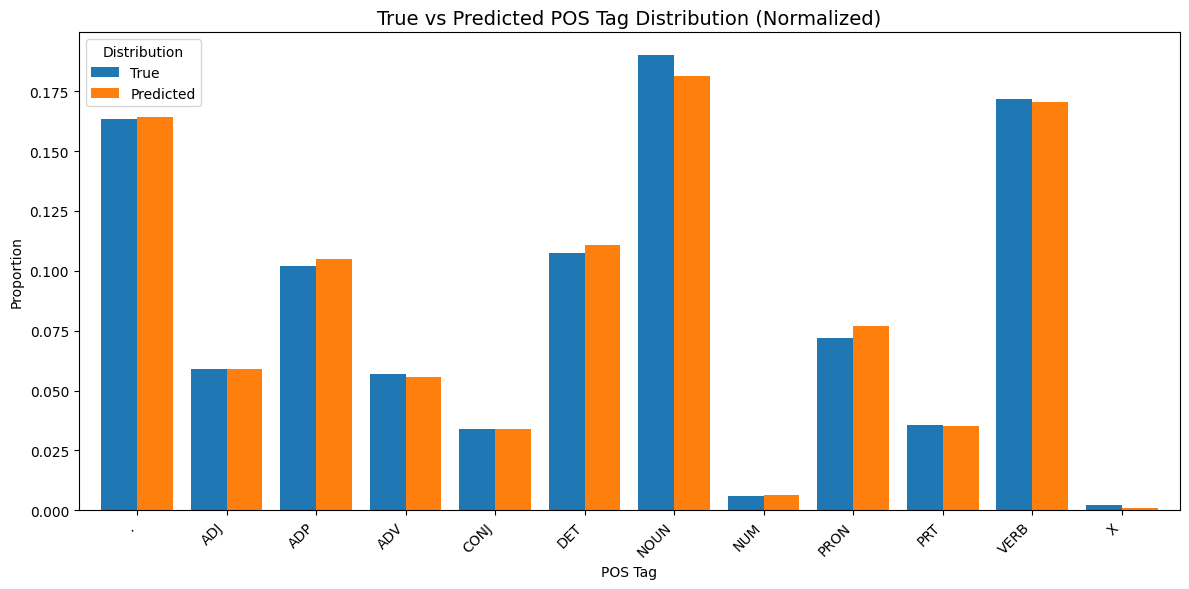

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def plot_distribution_shift(y_true, y_pred, labels=None):
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    true_dist = Counter(y_true)
    pred_dist = Counter(y_pred)

    df = pd.DataFrame({
        "True": [true_dist.get(t, 0) for t in labels],
        "Predicted": [pred_dist.get(t, 0) for t in labels]
    }, index=labels)

    # Normalize to proportions
    df_norm = df.div(df.sum(axis=0), axis=1)

    # Plot
    ax = df_norm.plot(kind="bar", figsize=(12, 6), width=0.8)
    plt.title("True vs Predicted POS Tag Distribution (Normalized)", fontsize=14)
    plt.xlabel("POS Tag")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Distribution")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_distribution_shift(y_true, y_pred, labels=sorted(list(hmm.tags)))